# Sentence Articulation

## Load Sentence

In [1]:
import timit_stats as ts
import gesture as ges
import os
import matplotlib.pyplot as plt

%pylab inline

root_dir = "../USC-TIMIT/EMA/Data/M1"
index = 0

t_names, m_names = zip(*ts.list_TIMIT_dir(root_dir))
trans_fname = t_names[index]
mat_fname = m_names[index]

# parse .trans file
t_starts, t_ends, phonemes, words, sentences = ts.parse_transcription(trans_fname)
phones = list(set(phonemes))
# parse .mat file
params, srates = ts.parse_mat(mat_fname)
print "Sentence \"{}\" loaded succesfully".format(trans_fname)

Populating the interactive namespace from numpy and matplotlib
Sentence "../USC-TIMIT/EMA/Data/M1\trans\usctimit_ema_m1_001_005.trans" loaded succesfully


## Calc Gestures And Variances

In [8]:
gestures = {}
means = {} # key : param_name, value: dict(ges, val)
variances = {} # key : param_name, value: dict(ges, val)

articulators = ["LL", "UL", "TT", "TB", "TD", "JAW"]
domains=["_x", "_y"]
param_names = [a+d for a in articulators for d in domains]

for i in range(len(t_names)):
    t_fname = t_names[i]
    mat_fname = m_names[i]
    gest = ts.calc_gestures(mat_fname, t_fname)
    for g in gest:
        if g not in gestures:
            gestures[g] = ges.Gesture(g)
        gestures[g].extend(gest[g])
print "gestures calculation finished"

gestures_norm, p_max, p_min = ts.normalize_gestures(gestures)

for p in param_names:
    means[p] = {}
    variances[p] = {}   

for g in gestures_norm:
    g_m = gestures_norm[g].get_mean()
    g_v = gestures_norm[g].get_variance()
    for p in param_names:
        means[p][g] = g_m[p]*(p_max[p]-p_min[p]) + p_min[p]
        variances[p][g] = g_v[p]

print "Means and variances calculated succesfully"

gestures calculation finished
Means and variances calculated succesfully


## Plot Sentence Phonemes

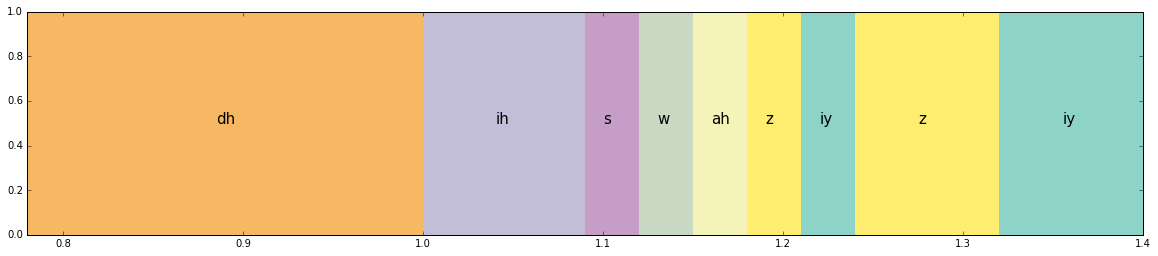

In [9]:
import matplotlib.patches as patches

cmap = plt.get_cmap('Set3')
colors = [cmap(i) for i in np.linspace(0, 1, len(phones))]
colors = dict(zip(phones, colors))

# show first 20 phonemes except first one ("silence")
show_start = 1
num_to_show = 9
show_last = min(len(phonemes), show_start + num_to_show)


fig1, ax1 = plt.subplots(figsize=(20, 4))
ax1.set_xlim(t_starts[show_start], t_ends[show_last-1])
ax1.set_ylim(0, 1.0)
for i in range(show_start, show_last):
    width = t_ends[i]-t_starts[i]
    height = 1.0
    ax1.add_patch(patches.Rectangle((t_starts[i], 0.0),
                                    width, height, color=colors[phonemes[i]]))  
    ax1.text(t_starts[i]+width/2-0.005, height/2, phonemes[i], fontsize=15)
plt.show()

#### Plot Articulators

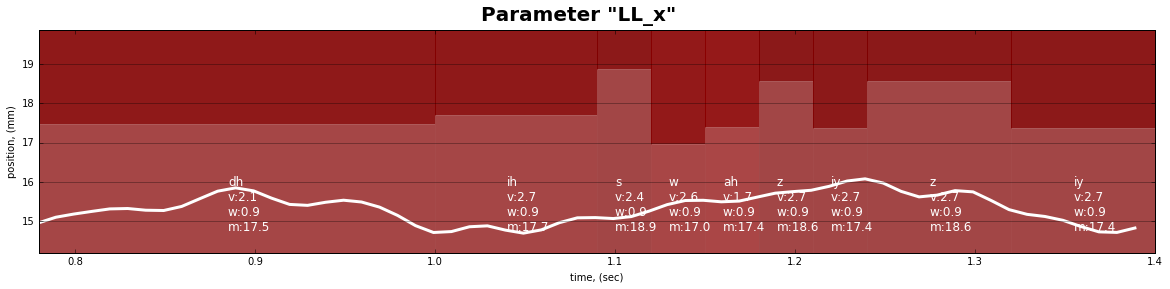

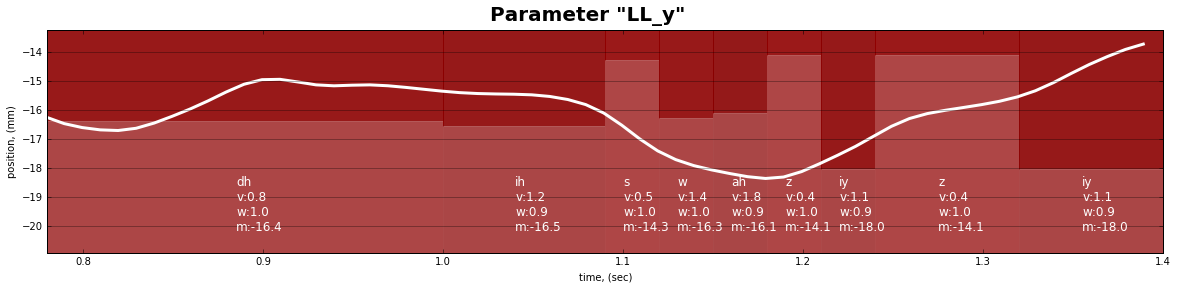

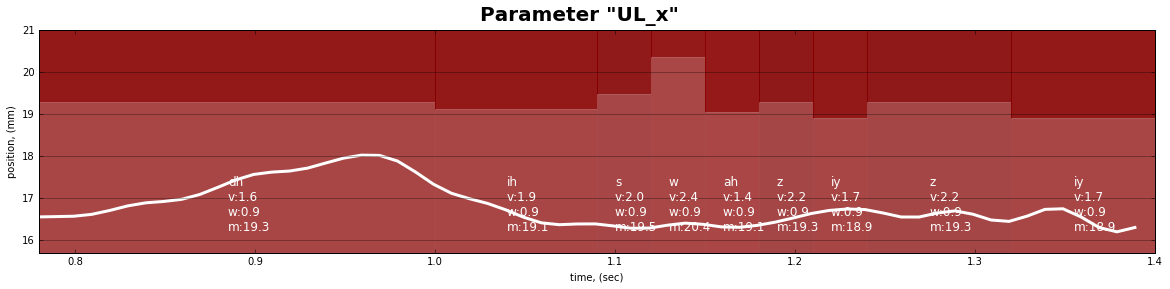

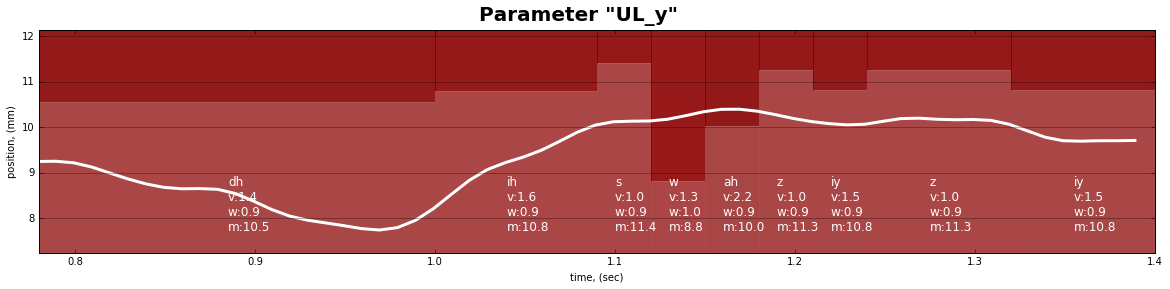

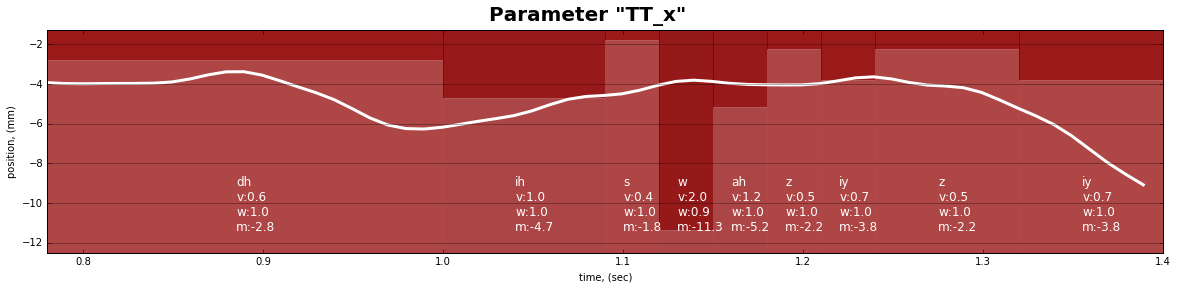

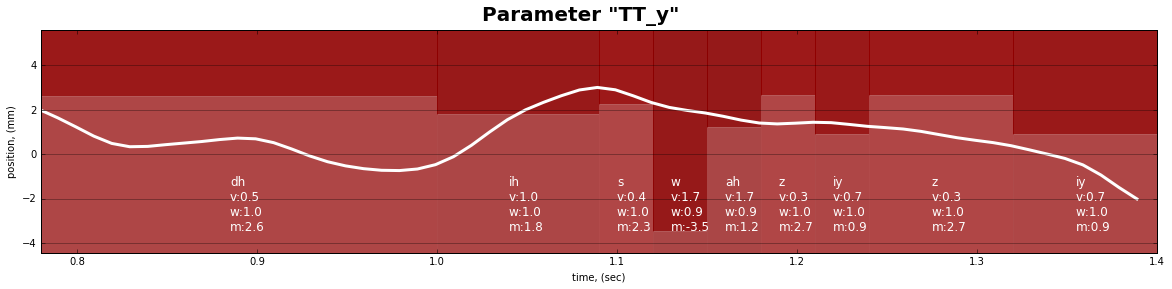

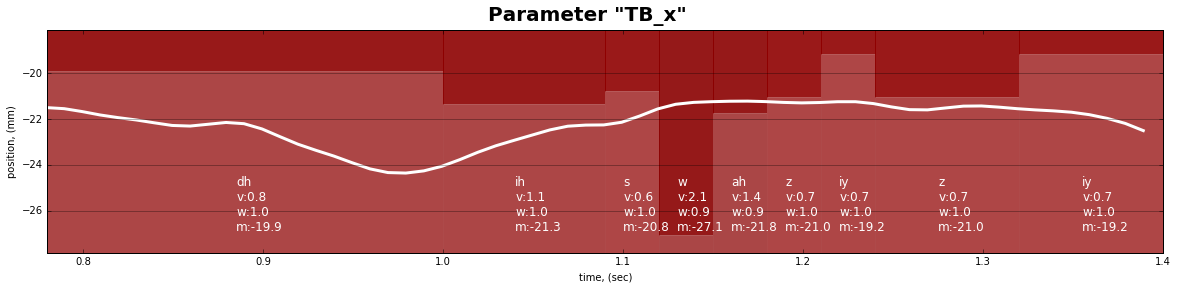

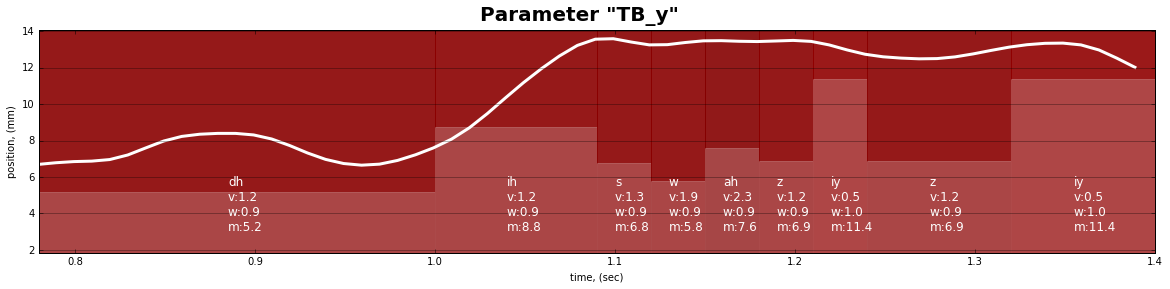

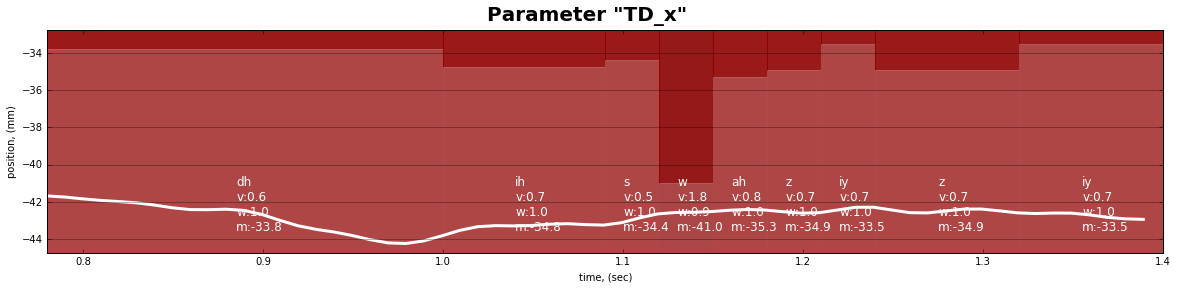

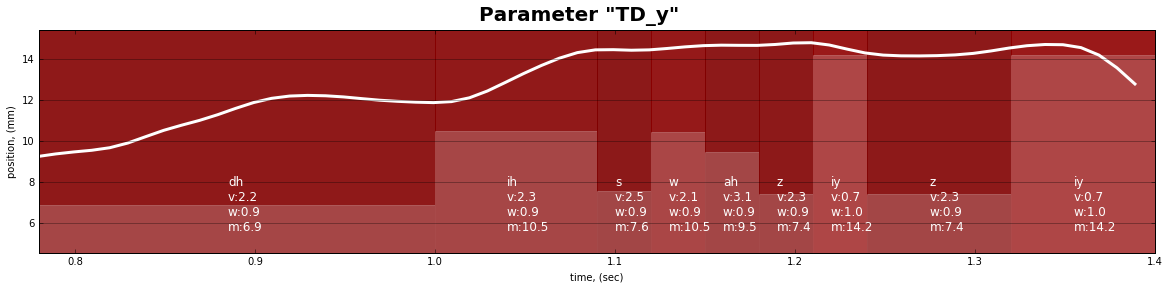

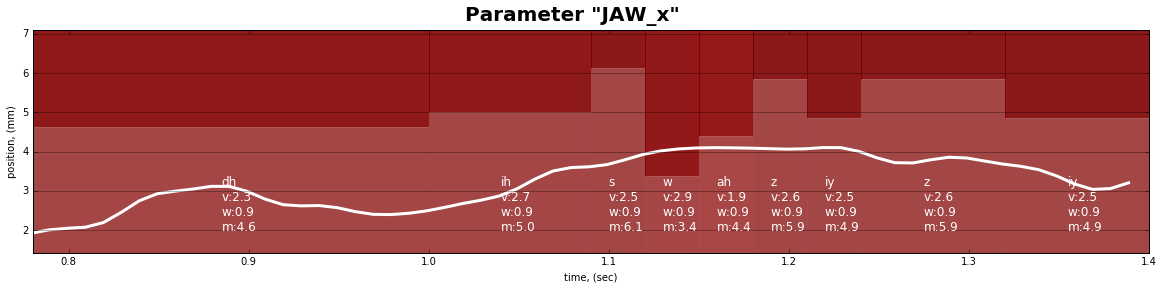

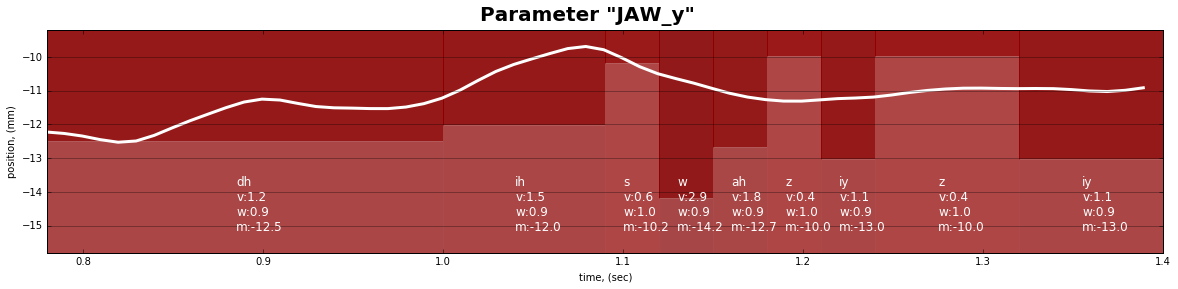

In [16]:
import copy

cmap = plt.get_cmap('gist_heat')
colors = [cmap(i) for i in range(100)]

for p in param_names:
# get min and max variance and means for p
    v_min = min(variances[p].itervalues())
    v_max = max(variances[p].itervalues())
    v_range = v_max - v_min
    m_min = min(means[p].itervalues())
    m_max = max(means[p].itervalues())
# prepare figure
    fig1, ax = plt.subplots(figsize=(20, 4))
    fig1.suptitle("Parameter \"{}\"".format(p),
                  fontsize=20, fontweight='bold')
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=0.3, axis='y')
    ax.set_xlabel("time, (sec)")
    ax.set_ylabel("position, (mm)")
# calc range    
    ax.set_xlim(t_starts[show_start], t_ends[show_last-1])
    
    rate = srates[p]
    i_start = int(t_starts[show_start] * rate)
    i_end = int(t_ends[show_last-1] * rate)
    length = i_end - i_start
    y = params[p][i_start:i_end]
    p_min = min(min(y), m_min) - 0.5
    p_max = max(max(y), m_max) + 0.5
    
    ax.set_ylim(p_min, p_max)
    height = p_max - p_min
    
    for i in range(show_start, show_last):
        phone = phonemes[i]
        v = variances[p][phone]
        varian = gestures_norm[phone].get_variance()
        w = 1.0 - varian[p]/ sum(varian.values())
        #       w is weight of parameter for this gesture
#         w = 1 - (gestures_norm[phone].get_variance[p] v-v_min)/(v_max-v_min)
        m = means[p][phone]
        clr = colors[int(w*100)-1]
        
        width = t_ends[i]-t_starts[i]
        ax.add_patch(patches.Rectangle((t_starts[i], p_min),
                                       width, height, color=clr, alpha=0.9))
        ax.add_patch(patches.Rectangle((t_starts[i], p_min),
                                       width, m - p_min, color="w", alpha=0.2))
        text1 =  "{0}\nv:{1:0.1f}\nw:{2:0.1f}\nm:{3:0.1f}".format(phonemes[i], v*100, w, m)
        ax.text(t_starts[i]+width/2-0.005,
                p_min+height/10, text1, fontsize=12, color='w')

   
    t = range(i_start,i_end)
    t = [i / srates[p] for i in t]
    ax.plot(t, y, color="w", linewidth=3)
    
    plt.show()
    

